In [30]:
from sklearn.model_selection import train_test_split
from src.baseline_experiments import *

from sklearn.cluster import AgglomerativeClustering
import gudhi as gd
import pandas as pd
import sklearn
from gale import create_mapper
import kmapper as km
import numpy as np
import glob
from mountaineer import Mountaineer
from gale import create_mapper

## Import Diabetes dataset

In [31]:
df = pd.read_csv("../dataset/diabetes.csv")
df.drop(columns=["p_id"], inplace=True)

In [32]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

## Train a neural network model with two hidden layers

In [18]:
batch_size = 16
num_epochs = 80
learning_rate = 4e-3
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train_tens = torch.tensor(X_train.to_numpy()).float()
X_test_tens = torch.tensor(X_test.to_numpy()).float()

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
    
averaging = 'binary'
y_train_tens = torch.tensor(y_train.to_numpy()).view(-1, 1).float()
output_dim = 1

In [20]:
device = torch.device("cpu")

dataset_tens = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
train_iter = torch.utils.data.DataLoader(dataset_tens, batch_size, shuffle=False)

print("Try to load the model..")
model = nn_model.get_model(device, train_iter, X_train.shape[1], output_dim, averaging, learning_rate, num_epochs)

Try to load the model..
Train model
Epoch 020: | Loss: 0.30523 | Acc: 86.654 | F1: 79.20633
Epoch 040: | Loss: 0.28288 | Acc: 90.462 | F1: 85.07238
Epoch 060: | Loss: 0.20930 | Acc: 92.577 | F1: 88.17563
Epoch 080: | Loss: 0.18856 | Acc: 92.077 | F1: 87.61079
Set to eval


In [21]:
X_test_tens = torch.tensor(X_test.to_numpy()).float()

X_test_c, Y_test_c = get_correct_predictions(model,X_test.reset_index(drop=True),X_test_tens,y_test.reset_index(drop=True),averaging)
X_test_c_tens = torch.from_numpy(X_test_c.to_numpy(dtype=np.float32))

X_test of correct predictions shape: (146, 8)
Y_test of correct predictions shape: (146,)
Label in Y_test of correct predictions ratio: 
 [[ 0 98]
 [ 1 48]]


## Use the sigmoid function as the prediction probability function for Mapper

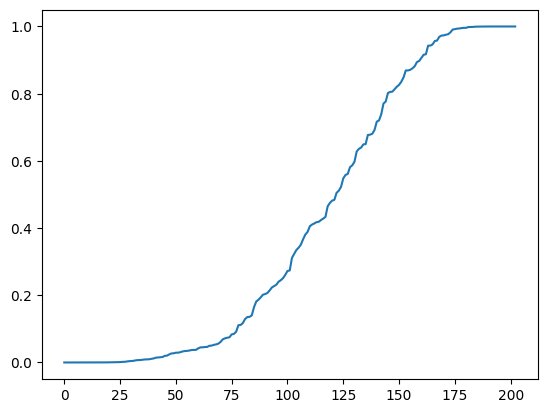

In [22]:
predictions = torch.sigmoid(model(X_test_tens)).detach().numpy()
plt.plot(np.sort(predictions.flatten()))

## Compute the Explanations of (IntGrad, SHAP, DeepLIFT) $\times$ (Zero, Max Distances, Uniform, Gaussian, Train)-Baselines (15 explanation outputs in total)


In [23]:
np.random.seed(rs)
torch.manual_seed(rs)

print("Loading all baselines..")
bun = BaselineUtilTensor()
black_baseline = bun.create_black_baseline(X)
uniform_baseline = bun.create_uniform_baseline(X)
gaussian_baseline = bun.create_gaussian_baseline(X, 0.5)
train_baseline = bun.create_train_baseline(X)

Loading all baselines..


In [11]:
explanations = {}
methods = ['IG','DeepSHAP','DeepLIFT']
target = None
for method in methods:
    bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr = get_attr_scores(method, X_test_tens, None, black_baseline,uniform_baseline,gaussian_baseline, train_baseline, model,X.min(), X.max(), X.columns)
    explanations[method] = [bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr]
    #for exp in explanations[method]:
        #exp[exp>5]=5
        #exp[exp<-5]=-5

Start integrated gradients for correct predictions with black_baseline
--- '0.25' seconds computation time ---
Start integrated gradients for correct predictions with max_dist_baseline
--- '1.08' seconds computation time ---
Start integrated gradients for correct predictions with uniform_baseline
--- '1.95' seconds computation time ---
Start integrated gradients for correct predictions with gaussian_baseline
--- '2.02' seconds computation time ---
Start integrated gradients for correct predictions with train_baseline
--- '2.06' seconds computation time ---
Start DeepSHAP for correct predictions with black_baseline
--- '0.24' seconds computation time ---
Start DeepSHAP for correct predictions with max_dist_baseline
--- '0.36' seconds computation time ---
Start DeepSHAP for correct predictions with uniform_baseline
--- '2.24' seconds computation time ---
Start DeepSHAP for correct predictions with gaussian_baseline
--- '2.41' seconds computation time ---
Start DeepSHAP for correct predic

In [24]:
baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']

## Plotting the variances for explanation values from different methods and baselines

In [25]:
import sklearn
mapper1 = create_mapper(explanations['IG'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper2 = create_mapper(explanations['IG'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper3 = create_mapper(explanations['IG'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper4 = create_mapper(explanations['IG'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper5 = create_mapper(explanations['IG'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))

mapper6 = create_mapper(explanations['DeepSHAP'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper7 = create_mapper(explanations['DeepSHAP'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper8 = create_mapper(explanations['DeepSHAP'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper9 = create_mapper(explanations['DeepSHAP'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper10 = create_mapper(explanations['DeepSHAP'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))


mapper11 = create_mapper(explanations['DeepLIFT'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper12 = create_mapper(explanations['DeepLIFT'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper13 = create_mapper(explanations['DeepLIFT'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper14 = create_mapper(explanations['DeepLIFT'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper15 = create_mapper(explanations['DeepLIFT'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))


In [28]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [33]:
#visualize
test = Mountaineer()
mapper_outputs=[mapper1, mapper2, mapper3, mapper4, mapper5, mapper6, mapper7, mapper8, mapper9, mapper10, mapper11, mapper12, mapper13, mapper14, mapper15]
color_values = [np.array([np.squeeze(i) for i in predictions])]
test.visualize(X_test.to_numpy(),y_test.to_numpy(), mapper_outputs, color_values, np.array(X.columns), 'UMAP') #Projection method- 'UMAP' or 'TSNE'

In [59]:
np.array(X.columns)

array(['no_times_pregnant', 'glucose_concentration', 'blood_pressure',
       'skin_fold_thickness', 'serum_insulin', 'bmi', 'diabetes pedigree',
       'age'], dtype=object)

In [93]:
X_test_C

NameError: name 'X_test_C' is not defined

In [73]:
Y_test

NameError: name 'Y_test' is not defined

In [89]:
y_test.to_numpy().size

203

In [105]:
X_test_c

,no_times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,diabetes pedigree,age
0,9,91,68,0,0,24.2,0.200,58
1,0,78,88,29,40,36.9,0.434,21
2,6,96,0,0,0,23.7,0.190,28
3,1,189,60,23,846,30.1,0.398,59
4,1,86,66,52,65,41.3,0.917,29
...,...,...,...,...,...,...,...,...
198,13,126,90,0,0,43.4,0.583,42
199,2,98,60,17,120,34.7,0.198,22
200,1,124,74,36,0,27.8,0.100,30
201,9,152,78,34,171,34.2,0.893,33


In [101]:
X_test_tens.size()

torch.Size([203, 8])